In [1]:
using Revise
# Tensor_trains 
using TensorTrains, TensorCast, Tullio, LogarithmicNumbers, ProgressMeter, LinearAlgebra
using TensorTrains: compress, TruncBondThresh  
using Printf

# MonteCarlo
using Random, Statistics, Distributions

# Graphics
using Plots, Colors

includet("tensor_builder.jl")
includet("calculo_observables.jl")
includet("monte_carlo_swap.jl")
includet("parallel_monte_carlo_Glauber.jl")
includet("special_swap.jl")

includet("efficient_observables.jl")

In [2]:
N = 10                                 # Número de espines
params = parallel_random_params(N)  
bt = boltzman_tt(params)  
normalize!(bt)

9.241614843889742

In [3]:
"""
    plot_two_sextuples(times, Sdots, Slines; site_labels=nothing, savepath=nothing)

Grafica dos series temporales de vectores por sitio:
- `times`: vector de tiempos (length T)
- `Sdots`: datos para graficar como puntos — forma N×T o T×N
- `Slines`: datos para graficar como líneas — forma N×T o T×N

Cada fila i corresponde al sitio i. Si la entrada viene en orientación time×sites,
la función la transpone automáticamente.

Opciones:
- `site_labels`: vector de etiquetas para leyenda (por defecto "Sitio 1", ...).
- `savepath`: si no es `nothing` guarda la figura en ese archivo (PNG, PDF, ...).
"""
function plot_two_Ntuples(times, Sdots, Slines; site_labels=nothing, titled="Marginal expectation per spin over steps", savepath=nothing)
    # Normalizar formatos: queremos N × T
    if size(Sdots,1) == length(times) && size(Sdots,2) != length(times)
        Sdots = permutedims(Sdots)   # T×N -> N×T
    end
    if size(Slines,1) == length(times) && size(Slines,2) != length(times)
        Slines = permutedims(Slines)
    end

    @assert size(Sdots) == size(Slines) "Sdots y Slines deben tener la misma forma"
    N, T = size(Sdots)
    @assert length(times) == T "length(times) debe coincidir con número de columnas en Sdots/Slines"

    # Etiquetas por sitio
    if site_labels === nothing
        site_labels = ["Sitio $i" for i in 1:N]
    else
        @assert length(site_labels) == N "site_labels debe tener longitud N"
    end

    cols = distinguishable_colors(N)  # paleta con N colores distinguibles

    p = plot(title=titled,
             xlabel="Tiempo", ylabel="Valor",
             legend=:outerright, grid=true, size=(900,500))

    # Dibujar: línea para Slines (con label) y puntos para Sdots (sin duplicar labels)
    for i in 1:N
        plot!(p, times, Slines[i, :],
              color=cols[i], linewidth=2, label=site_labels[i])
        scatter!(p, times, Sdots[i, :],
                 color=cols[i], marker=:circle, markersize=4, label=false)
    end

    if savepath !== nothing
        savefig(p, savepath)
    end

    return p
end

plot_two_Ntuples

Magnetización paralela: [-0.044, -0.024, -0.066, 0.062, -0.036, 0.006, -0.098, 0.03, -0.022, -0.038, 0.13, 0.064, -0.07, -0.014, -0.094, 0.108, 0.166, -0.112, -0.046, 0.046, 0.092, -0.054, 0.088, -0.066, 0.004, 0.008, -0.04, -0.088, 0.02, -0.034, -0.084, 0.03, -0.01, 0.102, -0.12, 0.048, 0.022, -0.112, -0.024, 0.032, 0.098, -0.048, 0.09, 0.04, 0.064, 0.124, -0.014, -0.088, -0.032, 0.012, 0.124, 0.078, 0.132, -0.032, 0.03, 0.026, -0.046, -0.044, 0.116, -0.006, -0.012, 0.05, -0.098, 0.1, -0.096, 0.084, -0.124, -0.19, -0.182, -0.052, 0.054, 0.104, -0.038, 0.04, -0.176, -0.072, 0.03, 0.166, -0.092, 0.052]
Magnetización secuencial: [-0.028, 0.002, -0.03, 0.02, 0.032, -0.022, -0.108, 0.064, 0.054, -0.024, 0.14, 0.108, -0.074, 0.01, -0.068, 0.006, 0.162, -0.098, -0.058, 0.02, 0.13, -0.032, 0.102, -0.052, 0.014, 0.058, -0.116, -0.124, 0.056, -0.09, -0.082, 0.018, -0.088, 0.09, -0.122, 0.058, 0.062, -0.076, 0.018, 0.07, 0.096, -0.044, 0.132, 0.018, 0.036, 0.068, 0.056, -0.014, -0.01, 0.038, 0.1

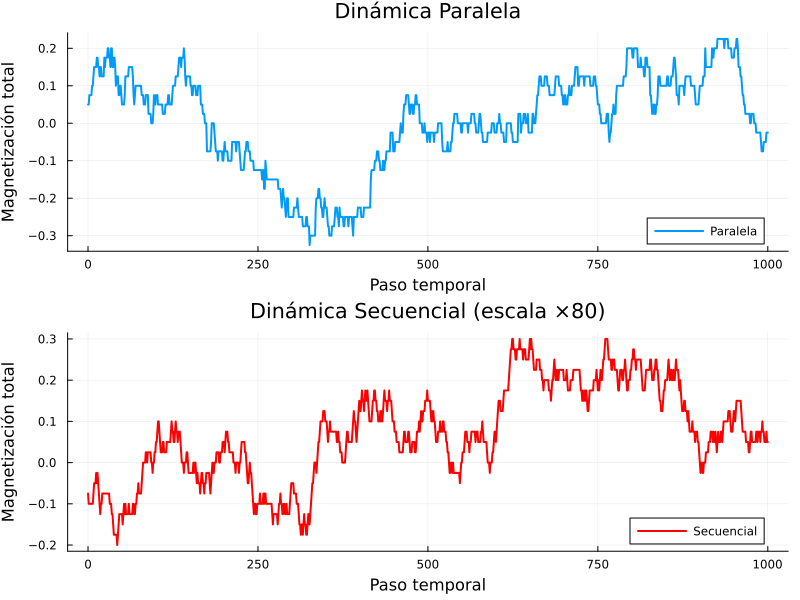

In [4]:
# ============================================
# CELDA 1: Importar el módulo
# ============================================

includet("monte_carlo_Glauber.jl")

using Random, Statistics
using Plots  # Si quieres graficar

# ============================================
# CELDA 2: Configurar parámetros
# ============================================

# Parámetros del sistema
N = 80
params = parallel_random_params(N)  
bt = boltzman_tt(params)  
normalize!(bt)

beta = params.beta_1
j_vector = params.j_vector  # Acoplamiento ferromagnético
h_vector = params.h_vector         # Sin campo externo
p0 = 1- 1/(N)

params = GlauberParams(beta, j_vector, h_vector, p0)


# Condición inicial
initial_probs = fill(0.5, N)
P0 = [[1-q, q] for q in initial_probs]

# ============================================
# CELDA 3: Ejecutar dinámica PARALELA
# ============================================

T_parallel = 1000
N_samples = 1000

result_parallel = run_monte_carlo(N, params, initial_probs, T_parallel; 
                                 N_samples=N_samples, seed=42, 
                                 save_trajectory=true)

# Magnetización final
mag_parallel = compute_magnetization(result_parallel)
println("Magnetización paralela: ", mag_parallel)

# ============================================
# CELDA 4: Ejecutar dinámica SECUENCIAL
# ============================================

# Nota: usamos N veces más pasos para tener escala temporal comparable
T_sequential = T_parallel

result_sequential = run_monte_carlo_sequential(N, params, initial_probs, T_sequential; 
                                              N_samples=N_samples, seed=42, 
                                              save_trajectory=true)

# Magnetización final
mag_sequential = compute_magnetization(result_sequential)
println("Magnetización secuencial: ", mag_sequential)

# ============================================
# CELDA 5: Comparar resultados
# ============================================

# Tabla comparativa
println("\n╔═══════╦═══════════╦═════════════╗")
println("║ Sitio ║  Paralela ║  Secuencial ║")
println("╠═══════╬═══════════╬═════════════╣")
for i in 1:N
    @printf("║  %2d   ║  %7.4f  ║   %7.4f   ║\n", 
            i, mag_parallel[i], mag_sequential[i])
end
println("╚═══════╩═══════════╩═════════════╝")

# ============================================
# CELDA 6: Visualizar trayectorias
# ============================================

# Escoger una muestra para visualizar
sample = 1

# Calcular magnetización total vs tiempo
mag_traj_par = compute_trajectory_magnetization(result_parallel, sample)
mag_traj_seq = compute_trajectory_magnetization(result_sequential, sample)

# Graficar
p1 = plot(0:T_parallel, mag_traj_par, 
         label="Paralela", lw=2, 
         xlabel="Paso temporal", 
         ylabel="Magnetización total",
         title="Dinámica Paralela",
         legend=:bottomright)

p2 = plot(0:T_sequential, mag_traj_seq, 
         label="Secuencial", lw=2, color=:red,
         xlabel="Paso temporal", 
         ylabel="Magnetización total",
         title="Dinámica Secuencial (escala ×$N)",
         legend=:bottomright)

plot(p1, p2, layout=(2,1), size=(800,600))


Ejecutando dinámica paralela (100 pasos)...
Ejecutando dinámica secuencial (8000 pasos)...

Comparación de magnetizaciones finales:
Sitio 1: Paralela = -0.05, Secuencial = -0.088
Sitio 2: Paralela = 0.014, Secuencial = 0.042
Sitio 3: Paralela = -0.046, Secuencial = -0.102
Sitio 4: Paralela = 0.128, Secuencial = 0.01
Sitio 5: Paralela = -0.066, Secuencial = -0.042
Sitio 6: Paralela = -0.018, Secuencial = -0.054
Sitio 7: Paralela = -0.068, Secuencial = -0.096
Sitio 8: Paralela = 0.006, Secuencial = 0.08
Sitio 9: Paralela = 0.0, Secuencial = 0.066
Sitio 10: Paralela = -0.02, Secuencial = 0.006
Sitio 11: Paralela = 0.12, Secuencial = 0.19
Sitio 12: Paralela = 0.036, Secuencial = 0.058
Sitio 13: Paralela = -0.124, Secuencial = -0.096
Sitio 14: Paralela = 0.02, Secuencial = -0.006
Sitio 15: Paralela = -0.076, Secuencial = -0.112
Sitio 16: Paralela = 0.086, Secuencial = 0.008
Sitio 17: Paralela = 0.108, Secuencial = 0.11
Sitio 18: Paralela = -0.116, Secuencial = -0.17
Sitio 19: Paralela = -0.

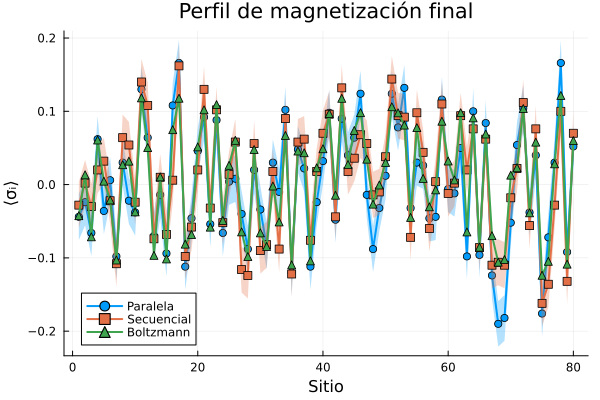

In [5]:

# ============================================
# CELDA 7: Comparación en misma escala
# ============================================

# Para comparar mejor, podemos submuestrear la secuencial cada N pasos
times_seq_resampled = 0:N:T_sequential
mag_seq_resampled = mag_traj_seq[1:N:end]

plot(0:T_parallel, mag_traj_par, 
     label="Paralela", lw=2, alpha=0.7,
     xlabel="Paso temporal (equivalente)", 
     ylabel="Magnetización total",
     title="Comparación de dinámicas")
plot!(times_seq_resampled ./ N, mag_seq_resampled, 
     label="Secuencial", lw=2, alpha=0.7, color=:red)

# ============================================
# CELDA 8: Usar función de comparación automática
# ============================================

# Alternativamente, usa la función que hace todo automáticamente
result_par, result_seq = compare_dynamics(N, params, initial_probs, 100; 
                                         N_samples=1000, seed=123)

# ============================================
# CELDA 9: Análisis de correlaciones
# ============================================

# Comparar correlaciones espaciales
println("\nCorrelaciones ⟨σ₁σⱼ⟩:")
println("Sitio j | Paralela | Secuencial")
println("--------|----------|------------")
for j in 1:N
    corr_par = compute_correlation(result_parallel, 1, j)
    corr_seq = compute_correlation(result_sequential, 1, j)
    @printf("  %2d    |  %6.3f  |   %6.3f\n", j, corr_par, corr_seq)
end

# ============================================
# CELDA 10: Graficar perfil de magnetización
# ============================================

# Perfil espacial de magnetización
err_par = compute_magnetization_error(result_parallel)
err_seq = compute_magnetization_error(result_sequential)

plot(1:N, mag_parallel, ribbon=err_par, 
     label="Paralela", lw=2, marker=:circle,
     xlabel="Sitio", ylabel="⟨σᵢ⟩",
     title="Perfil de magnetización final",
     fillalpha=0.3)
plot!(1:N, mag_sequential, ribbon=err_seq, 
     label="Secuencial", lw=2, marker=:square,
     fillalpha=0.3)
plot!(1:N, full_simple_ev_system(bt), 
     label="Boltzmann", lw=2, marker=:^,
     fillalpha=0.3)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Longitud de energy: 1001


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Longitud de energy: 1001


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


Longitud de energy: 1001


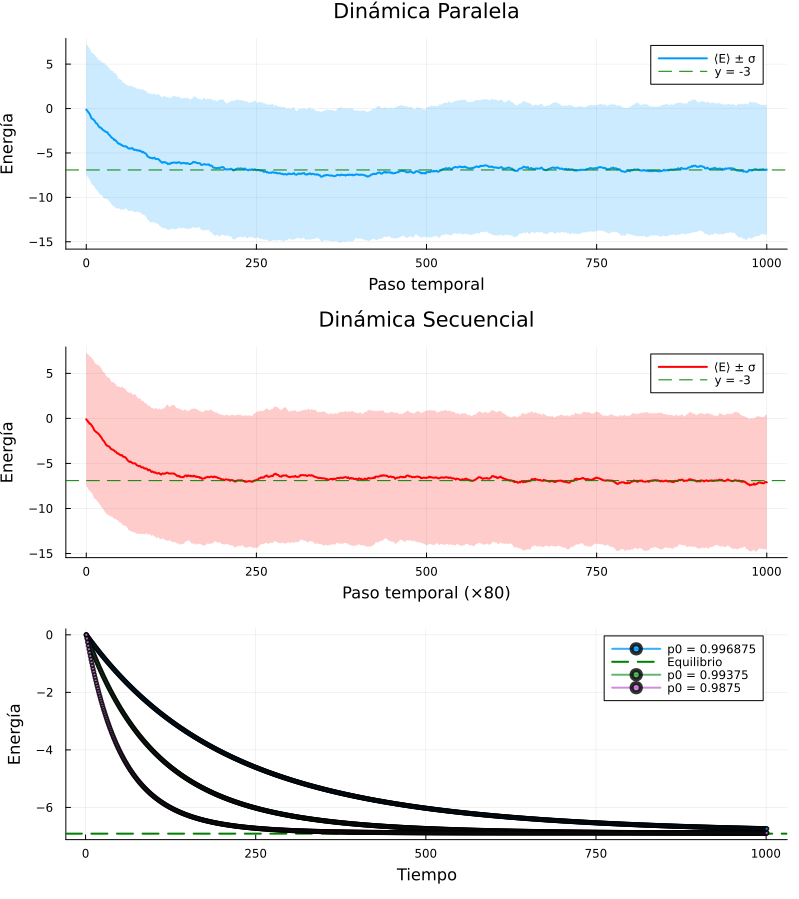

In [ ]:

# ============================================
# CELDA 11: Evolución temporal de la energía
# ============================================
bond = 5

# Calcular energía promedio para ambas dinámicas
energy_mean_par, energy_std_par = compute_average_trajectory_energy(result_parallel)
energy_mean_seq, energy_std_seq = compute_average_trajectory_energy(result_sequential)

# Graficar en la misma escala temporal (submuestrear secuencial cada N pasos)
times_par = 0:T_parallel
times_seq = (0:T_parallel)  # Escala equivalente

energy_seq_subsampled = energy_mean_seq[1:N:end]
energy_std_seq_subsampled = energy_std_seq[1:N:end]


attempt to save state beyond implementation limit
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Longitud de energy: 1001


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Longitud de energy: 1001


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Longitud de energy: 1001


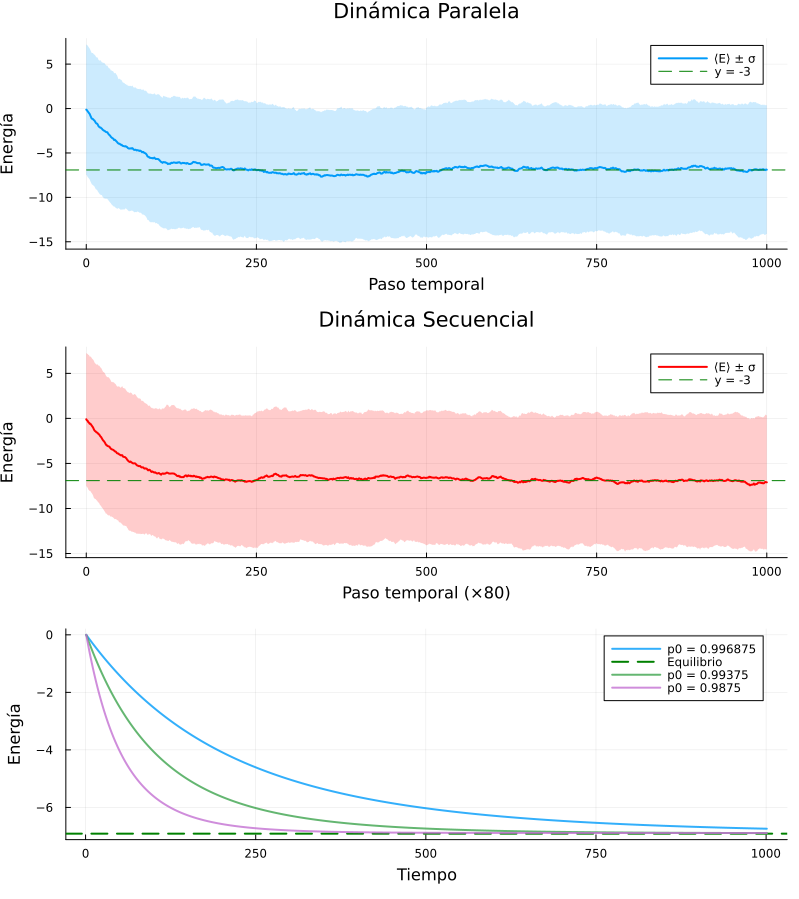

attempt to save state beyond implementation limit


In [ ]:

p_energy = plot(times_par, energy_mean_par, 
                ribbon=energy_std_par,
                label="Paralela", lw=2, alpha=0.7,
                xlabel="Paso temporal (equivalente)", 
                ylabel="Energía ⟨E⟩",
                title="Evolución temporal de la energía",
                legend=:best,
                fillalpha=0.2)

plot!(times_seq, energy_seq_subsampled, 
      ribbon=energy_std_seq_subsampled,
      label="Secuencial", lw=2, alpha=0.7, color=:red,
      fillalpha=0.2)

# Línea horizontal para energía de equilibrio (aproximada por el valor final)
hline!([energy_mean_par[end]], 
       linestyle=:dash, color=:black, label="Equilibrio (aprox.)", alpha=0.5)

display(p_energy)

# ============================================
# Versión alternativa: Gráficas separadas
# ============================================

p1_energy = plot(0:T_parallel, energy_mean_par, 
                 ribbon=energy_std_par,
                 label="⟨E⟩ ± σ", lw=2,
                 xlabel="Paso temporal", 
                 ylabel="Energía",
                 title="Dinámica Paralela",
                 legend=:best,
                 fillalpha=0.2)
hline!(p1_energy, [energy_function_simple(bt,params)], color=:green, linestyle=:dash, label="y = -3")


p2_energy = plot(0:T_sequential, energy_mean_seq, 
                 ribbon=energy_std_seq,
                 label="⟨E⟩ ± σ", lw=2, color=:red,
                 xlabel="Paso temporal (×$N)", 
                 ylabel="Energía",
                 title="Dinámica Secuencial",
                 legend=:best,
                 fillalpha=0.2)
hline!(p2_energy, [energy_function_simple(bt,params)], color=:green, linestyle=:dash, label="y = -3")


p = plot(xlabel="Tiempo", ylabel="Energía", legend=:best)


p0_values = [1- 1/(4*N),1- 1/(2*N),1- 1/2]

for (i, p0) in enumerate(p0_values)
     params_new = GlauberParams(
        beta,         # Mantén los valores originales
                # Cambia solo p0
        params.j_vector,
        params.h_vector,
        p0,
    )
    A = build_transition_tensorchain(transition_rate, params_new)
    B_t = tensor_b_t_over_time(A, P0, T_parallel, bond)
    energy = [energy_function_simple(bt, params_new) for bt in B_t]    
    
    # Verifica la longitud
    println("Longitud de energy: ", length(energy))
    
    # Asegúrate de que los ejes coincidan
    time_steps = 1:length(energy)
    
    plot!(p, time_steps, energy, 
        label="p0 = $(p0)", 
        lw=2, 
        # marker=:circle,
        markersize=2,
        alpha=0.8)
    
    # Línea de equilibrio
    if i == 1
        bt = boltzman_tt(params_new)  
        normalize!(bt)
        eq_energy = energy_function_simple(bt, params_new)
        hline!(p, [eq_energy], 
            color=:green, 
            linestyle=:dash, 
            lw=2,
            label="Equilibrio")
    end
end


plot(p1_energy, p2_energy, p, layout=(3,1), size=(800,900))


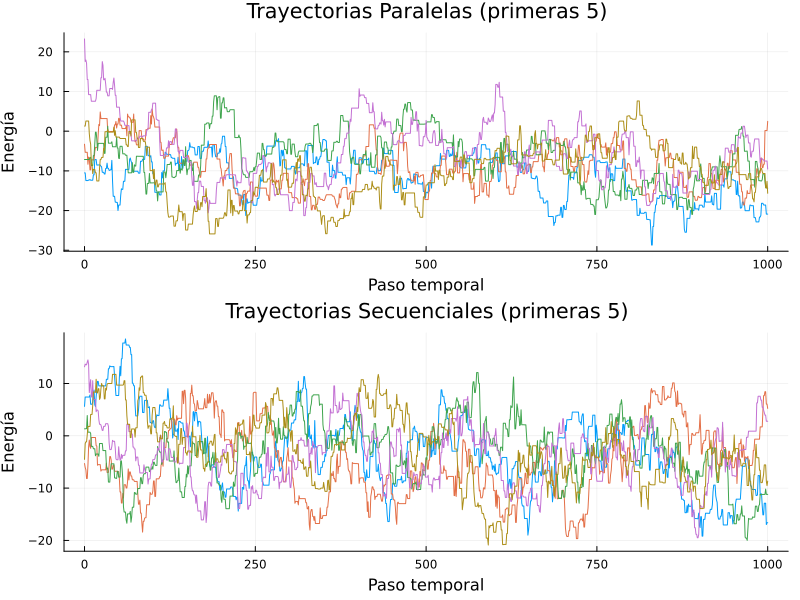

In [7]:

# ============================================
# Análisis adicional: Trayectorias individuales
# ============================================

# Comparar algunas trayectorias individuales
n_traj = 5  # Número de trayectorias a mostrar

p_traj_par = plot(xlabel="Paso temporal", ylabel="Energía",
                  title="Trayectorias Paralelas (primeras $n_traj)",
                  legend=false, alpha=0.6)

for sample in 1:n_traj
    energy_traj = compute_trajectory_energy(result_parallel, sample)
    plot!(p_traj_par, 0:T_parallel, energy_traj, lw=1)
end

p_traj_seq = plot(xlabel="Paso temporal", ylabel="Energía",
                  title="Trayectorias Secuenciales (primeras $n_traj)",
                  legend=false, alpha=0.6, color=:red)

for sample in 1:n_traj
    energy_traj = compute_trajectory_energy(result_sequential, sample)
    plot!(p_traj_seq, 0:T_sequential, energy_traj, lw=1)
end

plot(p_traj_par, p_traj_seq, layout=(2,1), size=(800,600))

In [8]:
# Solo para cadenas de N espines y 2 estados


function divide_by_constant!(B, constant)
    B.z *= constant
    return B
end

function glauber_sequential_transition(params, transition_rate, Q::Int = 2, σ = x -> 2x - 3)
    # Inferir N del tamaño de h_vector
    N = length(params.h_vector)
    
    # ============================================
    # Tensor inicial A1
    # ============================================

    function transition_event(i, params, transition_rate)
        if i == 1
            tt_i = Array{Float64, 4}[]
            A1 = zeros(1, Q, Q, Q)
            for sigma in 1:Q
                for sigma_plus in 1:Q
                    f_vector = zeros(1, Q)
                    for j in 1:Q
                        omega_j = σ(j)  # Valor de σ₂ᵗ
                        neighbors = [σ(sigma), omega_j]  # [σ₁ᵗ, σ₂ᵗ]
                        f_vector[1, j] = transition_rate(neighbors, σ(sigma_plus), 1, params)
                    end
                    A1[1, :, sigma, sigma_plus] = f_vector
                end
            end
            push!(tt_i, A1)
            push!(tt_i, [1 ; 0 ;;; 0 ; 0 ;;;; 0 ; 0 ;;; 0 ; 1])
            foreach(_ -> push!(tt_i, [1 ;;; 0 ;;;; 0 ;;; 1]) , 3:N)
        
        elseif i == N
            tt_i = Array{Float64, 4}[]
            foreach(_ -> push!(tt_i, [1 ;;; 0 ;;;; 0 ;;; 1]) , 1:N-2)
            push!(tt_i, [1  0;;; 0 0 ;;;; 0 0 ;;; 0 1])
            AN = zeros(Q, 1, Q, Q)
            for sigma in 1:Q         # σₙᵗ
                for sigma_plus in 1:Q # σₙᵗ⁺¹
                    f_vector = zeros(Q, 1)
                    for j in 1:Q
                        omega_j = σ(j)  # Valor de σₙ₋₁ᵗ
                        neighbors = [omega_j, σ(sigma)]  # [σₙ₋₁ᵗ, σₙᵗ]
                        f_vector[j, 1] = transition_rate(neighbors, σ(sigma_plus), N, params)
                    end
                    AN[:, 1, sigma, sigma_plus] = f_vector
                end
            end
            push!(tt_i, AN)

        else
            tt_i = Array{Float64, 4}[]
            foreach(_ -> push!(tt_i, [1 ;;; 0 ;;;; 0 ;;; 1]) , 1:i-2)
            push!(tt_i, [1  0;;; 0 0 ;;;;0 0 ;;; 0 1])

            Ai = zeros(Q, Q, Q, Q)
            for sigma in 1:Q         # σᵢᵗ
                for sigma_plus in 1:Q # σᵢᵗ⁺¹
            
                    F_matrix = zeros(Q, Q)
                
                    for k in 1:Q  # ωₖ = σᵢ₋₁ᵗ (vecino izquierdo)
                        for l in 1:Q  # ωₗ = σᵢ₊₁ᵗ (vecino derecho)
                            omega_k = σ(k)
                            omega_l = σ(l)
                            neighbors = [omega_k, σ(sigma), omega_l]  # [σᵢ₋₁ᵗ, σᵢᵗ, σᵢ₊₁ᵗ]
                            F_matrix[k, l] = transition_rate(neighbors, σ(sigma_plus), i, params)
                        end
                    end
                    Ai[:, :, sigma, sigma_plus] = F_matrix
                end
            end
            push!(tt_i, Ai)
            push!(tt_i, [1 ; 0 ;;; 0 ; 0 ;;;; 0 ; 0 ;;; 0 ; 1])
            foreach(_ -> push!(tt_i, [1 ;;; 0 ;;;; 0 ;;; 1]) , i+2:N)
        end
        return TensorTrain(tt_i)
    end

    tensors = transition_event(1, params, transition_rate)


    for i in 2:N
        tensors += transition_event(i, params, transition_rate)
        compress!(tensors, svd_trunc=TruncBond(bond))
    end
    divide_by_constant!(tensors, N)
    return tensors
end

        



glauber_sequential_transition (generic function with 3 methods)

In [9]:
A = glauber_sequential_transition(params, transition_glauber_rate)

TensorTrain{Float64, 4, Array{Float64, 4}, LogFloat64}([[0.7073017387734928 0.6526531130179329 -0.02387291283254542 -0.2705517481534455;;; 0.009150576463041201 0.27949766684579513 0.7204886564475953 0.6345812927501812;;;; 0.008518735326017697 -0.2622346660338913 0.693027867028246 -0.6714706148453697;;; 0.7068012085635065 -0.6535732156582404 0.006209306362989045 0.2706206715345395], [-0.7069734993476583 0.652348950083704 … 0.2720453184125604 -0.00025122981119684126; 0.0020214609626894075 -0.002254952227937259 … 0.00012740577025425196 -0.7271905986955417; -2.308788772271631e-5 0.004028804823432641 … -0.0038823325164196597 0.015775189436835497; 0.00014849927988566173 -0.00015695105407049638 … -0.00012712422561527223 -0.000572463329807444;;; -0.008801877222906833 0.28410774746034345 … -0.6531860706949744 0.023603962718399155; 0.0008539818340113308 -0.0013431891630661915 … 0.0008258953828134325 -0.0012799474379184721; 9.079236532246075e-5 -0.003502090945735046 … 0.008196712060632211 -0.0001

In [10]:
B_sequential = tensor_b_t_over_time(A, P0, T_parallel, bond);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


In [11]:
mag_tt_time = [full_simple_ev_system(B_sequential[k]) for k in 1:T_sequential];

In [12]:
function compute_marginal_magnetization_parallel(result)
    N_samples = size(result.trajectories, 1)
    N_x = size(result.trajectories, 2)
    T_x = size(result.trajectories, 3)
    mag_x = zeros(N_x, T_x)
    for t in 1:T_x
        for i in 1:N_x
            mag_x[i, t] = mean(result.trajectories[sample, i, t] for sample in 1:N_samples)
        end
    end
    return mag_x
end

compute_marginal_magnetization_parallel (generic function with 1 method)

In [13]:
mag_mc_time = compute_marginal_magnetization_parallel(result_sequential)

80×1001 Matrix{Float64}:
  0.022   0.014   0.018   0.02    0.024  …  -0.034  -0.032  -0.032  -0.028
 -0.018  -0.01   -0.01   -0.008  -0.004      0.02    0.02    0.014   0.002
  0.024   0.034   0.032   0.038   0.044     -0.036  -0.03   -0.026  -0.03
  0.006   0.0    -0.002  -0.004  -0.01       0.036   0.042   0.034   0.02
  0.02    0.02    0.022   0.022   0.01       0.038   0.04    0.032   0.032
  0.016   0.018   0.016   0.016   0.014  …  -0.018  -0.022  -0.022  -0.022
 -0.024  -0.03   -0.034  -0.034  -0.032     -0.106  -0.108  -0.106  -0.108
  0.05    0.05    0.046   0.044   0.038      0.076   0.072   0.064   0.064
  0.046   0.05    0.05    0.046   0.046      0.052   0.056   0.058   0.054
  0.018   0.018   0.012   0.012   0.008     -0.03   -0.024  -0.022  -0.024
  ⋮                                      ⋱                           ⋮
  0.004   0.002   0.004   0.002   0.0        0.126   0.12    0.118   0.112
 -0.034  -0.036  -0.036  -0.038  -0.044     -0.056  -0.066  -0.06   -0.056
  0.01

In [14]:
mag_tt_time[10]

80-element Vector{Float64}:
 -0.002582121487313016
  0.0011400941619241767
 -0.006587665557763023
  0.0059907766688656605
  0.0001676263377757281
 -0.003387388295345295
 -0.011793419505730929
  0.003715084367152399
  0.002849848045791026
 -0.0030280956905461287
  ⋮
  0.011011157444008268
 -0.0040092841454565376
  0.00749265205400218
 -0.01273450227097539
 -0.009854085891164932
  0.002414089748308479
  0.011759261636243301
 -0.011015346682873406
  0.007701519240250865

[0.0 -0.0007657127169248268 -0.0015227660936810716 -0.002271256729566573 -0.0030112802031768693 -0.003742931088912549 -0.004466302964838353 -0.005181488421738323 -0.0058885790719153674 -0.006587665557763023 -0.007278837560243723 -0.007962183807229906 -0.008637792081767237 -0.009305749230272664 -0.009966141170682508 -0.010619052900561143 -0.01126456850517582 -0.011902771165541004 -0.012533743166436129 -0.013157565904400481 -0.013774319895694387 -0.014384084784248963 -0.014986939349575956 -0.015582961514654936 -0.01617222835379689 -0.01675481610047097 -0.017330800155104076 -0.01790025509285642 -0.018463254671354457 -0.019019871838407698 -0.019570178739686694 -0.020114246726385232 -0.020652146362864165 -0.021183947434229466 -0.021709718953966617 -0.02222952917151788 -0.022743445579859856 -0.023251534923080297 -0.023753863203950676 -0.024250495691507834 -0.02474149692862354 -0.02522693073958321 -0.025706860237654727 -0.026181347832635316 -0.026650455238387605 -0.027114243480322653 -0.02757

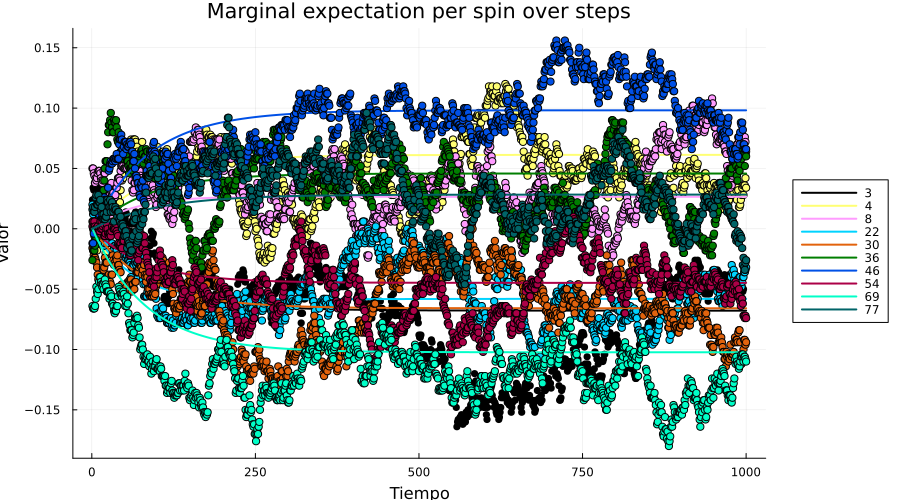

In [15]:
numbers_of_spins = 10
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)

for system in 1:1
    Sdots = mag_mc_time[lista_of_spins, 1:T_parallel] # N x T

    Slines = zeros(size(Sdots))   
                         # N x T
    for k in 1:T_parallel
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time[k][spin_idx]
        end
    end
    print(Slines)
    times = 1:T_parallel            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista,
                           savepath="sextuples_compare.png")
    display(p)
end



Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


Longitud de energy: 1001


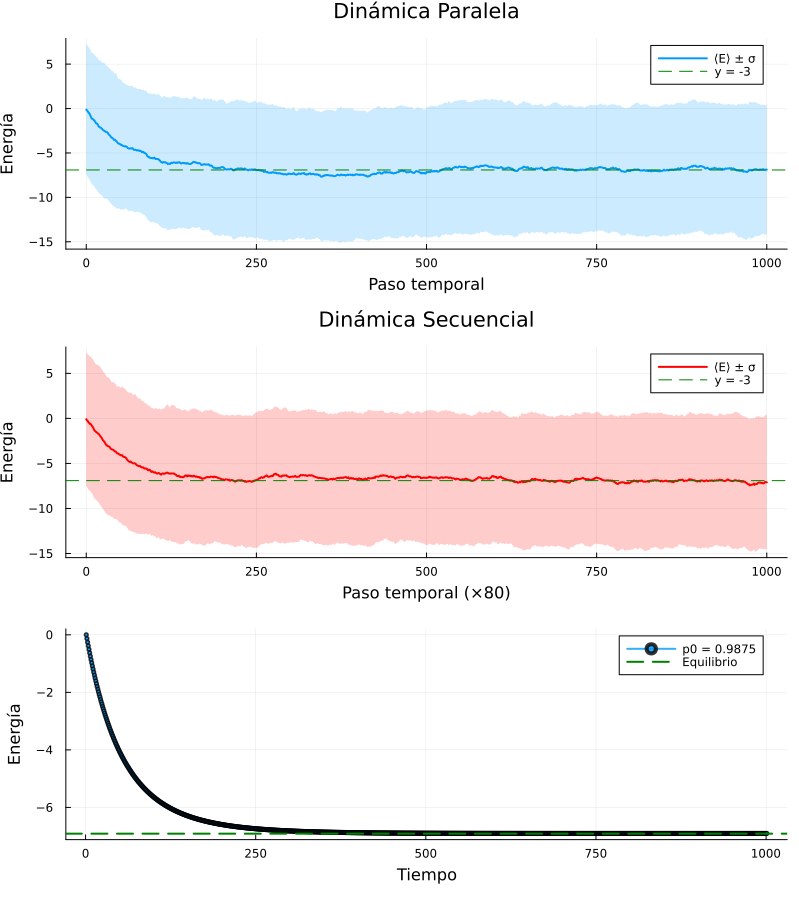

In [16]:

# ============================================
# CELDA 11: Evolución temporal de la energía
# ============================================


# Calcular energía promedio para ambas dinámicas
energy_mean_par, energy_std_par = compute_average_trajectory_energy(result_parallel)
energy_mean_seq, energy_std_seq = compute_average_trajectory_energy(result_sequential)

# Graficar en la misma escala temporal (submuestrear secuencial cada N pasos)
times_par = 0:T_parallel
times_seq = (0:T_parallel)  # Escala equivalente

energy_seq_subsampled = energy_mean_seq[1:N:end]
energy_std_seq_subsampled = energy_std_seq[1:N:end]

p_energy = plot(times_par, energy_mean_par, 
                ribbon=energy_std_par,
                label="Paralela", lw=2, alpha=0.7,
                xlabel="Paso temporal (equivalente)", 
                ylabel="Energía ⟨E⟩",
                title="Evolución temporal de la energía",
                legend=:best,
                fillalpha=0.2)

plot!(times_seq, energy_seq_subsampled, 
      ribbon=energy_std_seq_subsampled,
      label="Secuencial", lw=2, alpha=0.7, color=:red,
      fillalpha=0.2)

# Línea horizontal para energía de equilibrio (aproximada por el valor final)
hline!([energy_mean_par[end]], 
       linestyle=:dash, color=:black, label="Equilibrio (aprox.)", alpha=0.5)

display(p_energy)

# ============================================
# Versión alternativa: Gráficas separadas
# ============================================

p1_energy = plot(0:T_parallel, energy_mean_par, 
                 ribbon=energy_std_par,
                 label="⟨E⟩ ± σ", lw=2,
                 xlabel="Paso temporal", 
                 ylabel="Energía",
                 title="Dinámica Paralela",
                 legend=:best,
                 fillalpha=0.2)
hline!(p1_energy, [energy_function_simple(bt,params)], color=:green, linestyle=:dash, label="y = -3")


p2_energy = plot(0:T_sequential, energy_mean_seq, 
                 ribbon=energy_std_seq,
                 label="⟨E⟩ ± σ", lw=2, color=:red,
                 xlabel="Paso temporal (×$N)", 
                 ylabel="Energía",
                 title="Dinámica Secuencial",
                 legend=:best,
                 fillalpha=0.2)
hline!(p2_energy, [energy_function_simple(bt,params)], color=:green, linestyle=:dash, label="y = -3")


p = plot(xlabel="Tiempo", ylabel="Energía", legend=:best)



A = glauber_sequential_transition(params, transition_glauber_rate)
B_sequential = tensor_b_t_over_time(A, P0, T_parallel, bond)
energy = [energy_function_simple(bt, params) for bt in B_sequential] 
# Verifica la longitud
println("Longitud de energy: ", length(energy))

# Asegúrate de que los ejes coincidan
time_steps = 1:length(energy)

plot!(p, time_steps, energy, 
    label="p0 = $(p0)", 
    lw=2, 
    marker=:circle,
    markersize=2,
    alpha=0.8)


bt = boltzman_tt(params)  
normalize!(bt)
eq_energy = energy_function_simple(bt, params)
hline!(p, [eq_energy], 
    color=:green, 
    linestyle=:dash, 
    lw=2,
    label="Equilibrio")
    



plot(p1_energy, p2_energy, p, layout=(3,1), size=(800,900))
